# Alpaca-GPT4 Dataset Analysis

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys

sys.path.append('../')

# Make plots look nice
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All set with imports")

All set with imports


In [49]:
import os
from dotenv import load_dotenv
import wandb

load_dotenv()
wandb_api_key = os.getenv('WANDB_API_KEY')

if wandb_api_key:
    wandb.login(key=wandb_api_key)
    print("wandb connection working")
else:
    print("No wandb key found - need to fix the .env file")
    print("reminder: WANDB_API_KEY=actual_key in .env")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/khalil/.netrc


wandb connection working


In [50]:
# Starting a wandb run to track this exploration
wandb.init(
    project="dialog-model-training",
    name="data-exploration",
    tags=["data-analysis", "exploration"]
)

print("wandb tracking started")

wandb tracking started


## Loading the data

Test the postgres DB loading setup. Should fallback to file loading if DB isn't available.

In [51]:
# Getting DB env vars loaded properly
import os
import subprocess

def load_env_from_shell_script(script_path):
    """Custom function to actually load shell env vars into python process"""
    try:
        result = subprocess.run(
            f'source {script_path} && env',
            shell=True,
            capture_output=True,
            text=True,
            executable='/bin/bash'
        )
        
        if result.returncode == 0:
            env_vars = {}
            for line in result.stdout.split('\n'):
                if '=' in line and not line.startswith('_'):
                    key, value = line.split('=', 1)
                    env_vars[key] = value
                    os.environ[key] = value
            
            # Show what DB vars got loaded (mask password)
            db_vars = {k: v for k, v in env_vars.items() if k.startswith('DB_')}
            if db_vars:
                print("DB environment loaded:")
                for key, value in db_vars.items():
                    display_value = value if key != 'DB_PASSWORD' else '*' * len(value)
                    print(f"  {key}={display_value}")
                return True
            else:
                print("No DB vars found in script")
                return False
        else:
            print(f"Script error: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"Env loading failed: {e}")
        return False

# Load the environment
script_loaded = load_env_from_shell_script('../../set_db_env.sh')
if not script_loaded:
    print("Skipping DB setup - will use file loading instead")

DB environment loaded:
  DB_PASSWORD=**************
  DB_PORT=5432
  DB_USER=dnnuser
  DB_HOST=100.64.125.5


In [52]:
# Trying database first, fallback to files
from src.data.loaders import get_database_manager, get_dataset_manager
import os

dataset_manager = get_dataset_manager()
df = None
db_available = False

try:
    if os.getenv('DB_USER') and os.getenv('DB_PASSWORD'):
        print("DB credentials available, testing connection...")
        db_manager = get_database_manager()
        df = db_manager.load_from_database()
        db_available = True
        
        if df is not None and len(df) > 0:
            print("Got data from database")
        else:
            print("DB empty or table missing")
            df = None
    else:
        print("No DB credentials - using file loading")
        
except Exception as e:
    print(f"DB failed: {e}")
    print("Falling back to files...")

# File fallback
if df is None or len(df) == 0:
    print("Loading from file...")
    df = dataset_manager.load_dataset()
    
    # Try saving to DB if it's available
    if db_available:
        try:
            print("Saving to DB for next time...")
            success = db_manager.save_to_database(df)
            if success:
                print("Saved to DB successfully")
            else:
                print("DB save failed")
        except Exception as e:
            print(f"Couldn't save to DB: {e}")

print(f"\nLoaded: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

DB credentials available, testing connection...
Successfully loaded 52002 rows from table 'alpaca_gpt4_dataset'
Got data from database

Loaded: (52002, 4)
Columns: ['instruction', 'input', 'output', 'text']

First few rows:


,instruction,input,output,text
0,Give three tips for staying healthy.,,1. Eat a balanced and nutritious diet: Make su...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,An atom is the basic building block of all mat...,Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are several ways to reduce air pollution...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,"As an AI assistant, I do not have my own perso...",Below is an instruction that describes a task....


In [53]:
# Quick dataset overview
if df is not None:
    info = dataset_manager.get_dataset_info(df)
    dataset_manager.print_dataset_summary(df)

    # Log to wandb for tracking
    wandb.log({
        "dataset_size": len(df),
        "num_columns": len(df.columns),
        "memory_usage_mb": info['memory_usage'] / 1024**2
    })

    print(f"\nGot {len(df):,} examples")
    print(f"Memory: {info['memory_usage'] / 1024**2:.2f} MB")
else:
    print("No data loaded - something went wrong above")

Dataset Summary:
Shape: (52002, 4)
Columns: ['instruction', 'input', 'output', 'text']
Memory usage: 106.54 MB

Data types:
  instruction: object
  input: object
  output: object
  text: object

Null values:
  instruction: 0
  input: 0
  output: 0
  text: 0

First 3 rows:
                            instruction input  \
0  Give three tips for staying healthy.         
1    What are the three primary colors?         
2    Describe the structure of an atom.         

                                              output  \
0  1. Eat a balanced and nutritious diet: Make su...   
1  The three primary colors are red, blue, and ye...   
2  An atom is the basic building block of all mat...   

                                                text  
0  Below is an instruction that describes a task....  
1  Below is an instruction that describes a task....  
2  Below is an instruction that describes a task....  

Got 52,002 examples
Memory: 106.54 MB


## Text length analysis

Sequence lengths give hints about memory usage and model architecture.

In [54]:
# Getting basic length stats
if df is None:
    print("No data to analyze")
elif 'instruction' not in df.columns or 'output' not in df.columns:
    print("Missing required columns")
    print("Available:", list(df.columns))
else:
    print("Computing lengths...")
    
    df['instruction_length'] = df['instruction'].str.len()
    df['output_length'] = df['output'].str.len()
    df['total_length'] = df['instruction_length'] + df['output_length']

    # Word counts too
    df['instruction_words'] = df['instruction'].str.split().str.len()
    df['output_words'] = df['output'].str.split().str.len()

    # Check the distributions
    print("Length stats:")
    print("=" * 30)
    print("\nInstructions:")
    print(df['instruction_length'].describe())
    print("\nOutputs:")
    print(df['output_length'].describe())
    print("\nWord counts:")
    print(f"Avg instruction words: {df['instruction_words'].mean():.1f}")
    print(f"Avg output words: {df['output_words'].mean():.1f}")

Computing lengths...
Length stats:

Instructions:
count    52002.000000
mean        59.778759
std         21.193591
min          9.000000
25%         46.000000
50%         57.000000
75%         70.000000
max        489.000000
Name: instruction_length, dtype: float64

Outputs:
count    52002.000000
mean       677.368967
std        649.759513
min          1.000000
25%         99.000000
50%        471.000000
75%       1140.000000
max       4574.000000
Name: output_length, dtype: float64

Word counts:
Avg instruction words: 10.1
Avg output words: 109.7


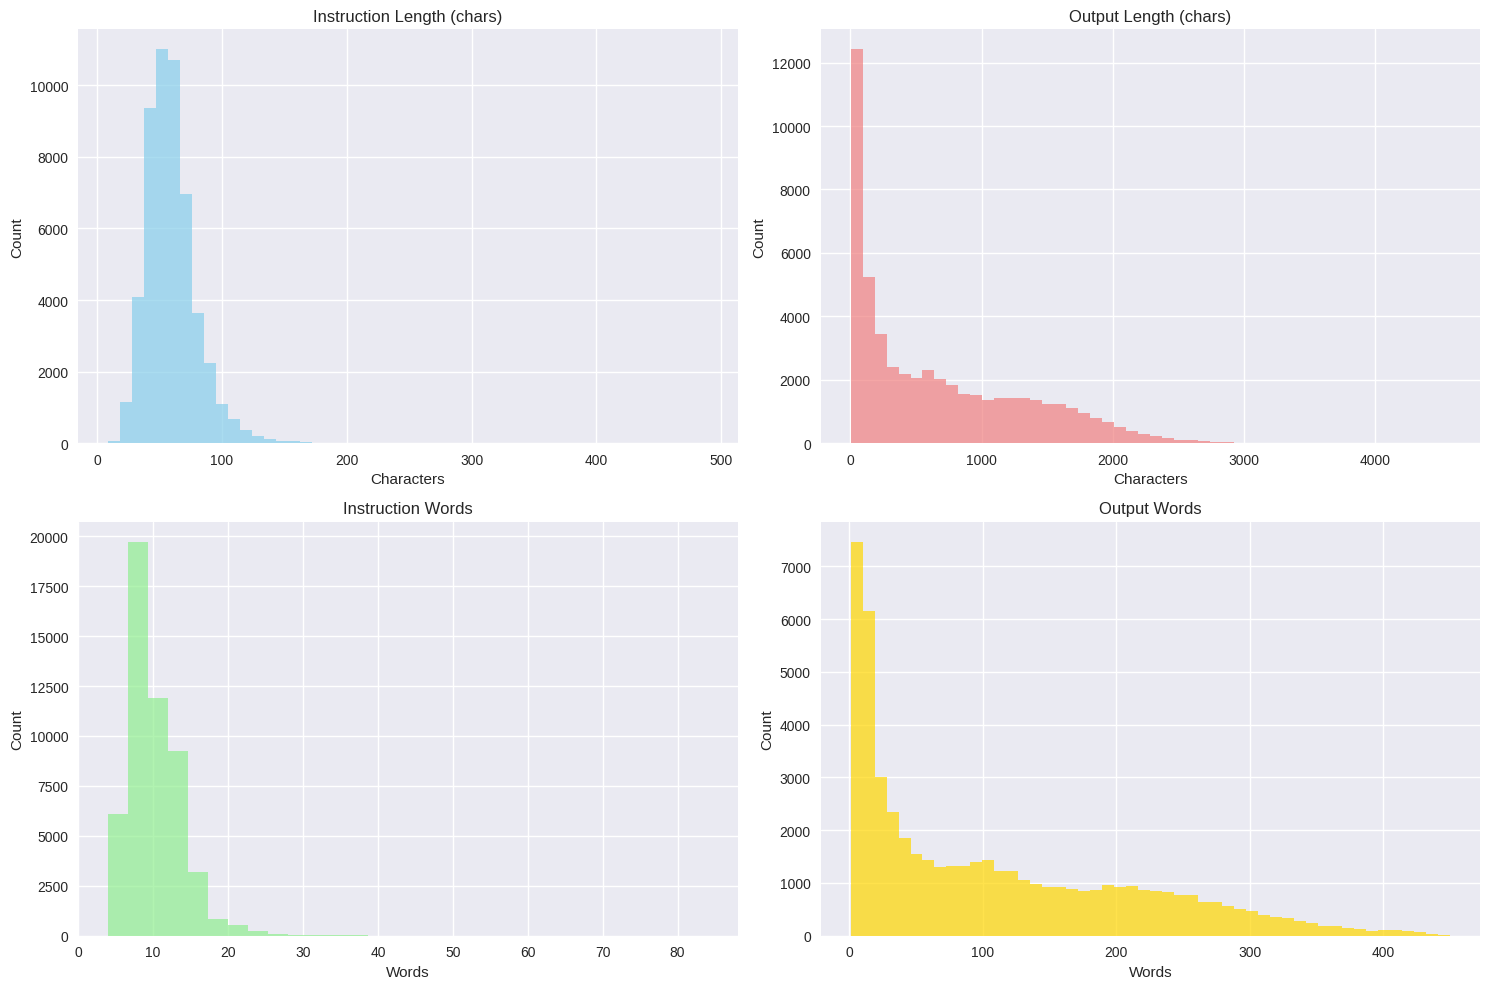

In [55]:
# Plotting length distributions
if df is None or 'instruction_length' not in df.columns:
    print("Can't plot - missing data or columns")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Instruction char lengths
    axes[0,0].hist(df['instruction_length'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Instruction Length (chars)')
    axes[0,0].set_xlabel('Characters')
    axes[0,0].set_ylabel('Count')

    # Output char lengths
    axes[0,1].hist(df['output_length'], bins=50, alpha=0.7, color='lightcoral')
    axes[0,1].set_title('Output Length (chars)')
    axes[0,1].set_xlabel('Characters')
    axes[0,1].set_ylabel('Count')

    # Word counts
    axes[1,0].hist(df['instruction_words'], bins=30, alpha=0.7, color='lightgreen')
    axes[1,0].set_title('Instruction Words')
    axes[1,0].set_xlabel('Words')
    axes[1,0].set_ylabel('Count')

    axes[1,1].hist(df['output_words'], bins=50, alpha=0.7, color='gold')
    axes[1,1].set_title('Output Words')
    axes[1,1].set_xlabel('Words')
    axes[1,1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Log these for tracking
    wandb.log({
        "avg_instruction_length": df['instruction_length'].mean(),
        "avg_output_length": df['output_length'].mean(),
        "avg_instruction_words": df['instruction_words'].mean(),
        "avg_output_words": df['output_words'].mean()
    })

## Data quality check

Quick sanity check for obvious issues that would mess up training.

In [56]:
# Basic quality checks
if df is None:
    print("No data to check")
elif 'instruction' not in df.columns or 'output' not in df.columns:
    print("Missing key columns")
else:
    print("Quality check:")
    print("=" * 20)
    missing_counts = df.isnull().sum()
    print(missing_counts)

    duplicate_count = df.duplicated().sum()
    print(f"\nDuplicates: {duplicate_count}")

    # Empty string check
    empty_instructions = (df['instruction'].str.strip() == '').sum()
    empty_outputs = (df['output'].str.strip() == '').sum()
    print(f"Empty instructions: {empty_instructions}")
    print(f"Empty outputs: {empty_outputs}")

    # Check for weird lengths
    if 'instruction_words' in df.columns and 'output_words' in df.columns:
        very_short_instructions = (df['instruction_words'] < 3).sum()
        very_long_outputs = (df['output_words'] > 500).sum()
        print(f"Too short instructions (<3 words): {very_short_instructions}")
        print(f"Too long outputs (>500 words): {very_long_outputs}")
    else:
        very_short_instructions = 0
        very_long_outputs = 0
        print("No word counts available")

    # Overall quality score
    quality_metrics = {
        "missing_values": missing_counts.sum(),
        "duplicate_rows": duplicate_count,
        "empty_instructions": empty_instructions,
        "empty_outputs": empty_outputs,
        "very_short_instructions": very_short_instructions,
        "very_long_outputs": very_long_outputs,
        "data_quality_score": 1 - (missing_counts.sum() + duplicate_count + empty_instructions + empty_outputs) / len(df)
    }

    wandb.log(quality_metrics)
    print(f"\nQuality score: {quality_metrics['data_quality_score']:.3f}")

Quality check:
instruction           0
input                 0
output                0
text                  0
instruction_length    0
output_length         0
total_length          0
instruction_words     0
output_words          0
dtype: int64

Duplicates: 0
Empty instructions: 0
Empty outputs: 0
Too short instructions (<3 words): 0
Too long outputs (>500 words): 0

Quality score: 1.000


## Sample examples

Quick look at actual data to see what we're working with.

In [57]:
# Look at some random examples
if df is None or len(df) == 0:
    print("No data to sample")
else:
    print("Random examples:")
    print("=" * 40)

    sample_size = min(3, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)

    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        print(f"\nExample {i+1}:")
        print(f"Instruction: {row['instruction']}")
        print(f"Input: {row['input']}")
        print(f"Output: {row['output']}")
        
        if 'instruction_words' in df.columns and 'output_words' in df.columns:
            print(f"Length: {row['instruction_words']} → {row['output_words']} words")
        print("-" * 40)

Random examples:

Example 1:
Instruction: Extract the topic of the given story.
Input: James and his family were camping in the lake near their house. They built a tent and enjoyed a campfire and some marshmallows.
Output: The topic of the story is camping.
Length: 7 → 7 words
----------------------------------------

Example 2:
Instruction: Unscramble the letters and identify the word.
Input: kxnao
Output: The word is "axion".
Length: 7 → 4 words
----------------------------------------

Example 3:
Instruction: Grade this student's essay on the Great Gatsby.
Input: The Great Gatsby is a timeless classic about people's attitudes towards love, money, and power. It offers an account of the life and times of Jay Gatsby and his friends and lovers, and provides readers with insights into the pursuit of the American Dream, the pitfalls of materialism and the power of relationships. 

The novel is set in the summer of 1922, when the roaring stock market, extreme wealth, and indulgence are eve

In [58]:
# Plotly charts to explore the data patterns more interactively.
if df is None:
    print("No data for interactive plots")
elif 'instruction_words' not in df.columns or 'output_words' not in df.columns:
    print("Need word counts first")
else:
    # Scatter plot of instruction vs output lengths
    sample_df = df.sample(min(1000, len(df)))
    fig = px.scatter(
        sample_df,
        x='instruction_words',
        y='output_words',
        title='Instruction vs Output Length',
        labels={'instruction_words': 'Instruction Words', 'output_words': 'Output Words'},
        opacity=0.6
    )
    fig.show()

    # Box plots for length comparison
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['Instructions', 'Outputs']
    )

    fig.add_trace(
        go.Box(y=df['instruction_words'], name='Instructions'),
        row=1, col=1
    )

    fig.add_trace(
        go.Box(y=df['output_words'], name='Outputs'),
        row=1, col=2
    )

    fig.update_layout(title_text="Length Distributions", showlegend=False)
    fig.show()

## Notes for implementation

52k examples, quality score 1.0 - clean data, minimal duplicates/missing values.

The 11x expansion ratio (instruction → response) means encoder-decoder probably works better than decoder-only:
- T5-style models handle input→output transformations better with separate attention mechanisms
- Encoder can compress the short instruction into good representations that the decoder can expand from
- GPT-style models have to "remember" the short instruction while generating much longer responses, which is trickier

95th percentile at 1930 chars → `max_position_embeddings: 2048` should cover most cases.

22% of responses >200 words could hit memory limits, so need:
- Gradient checkpointing: trades compute for memory by recomputing activations during backprop instead of storing them. Cuts memory ~50% but slows training ~20%
- Dynamic padding: batch similar-length sequences instead of padding everything to max length
- fp16: halves memory for activations and gradients

Token math: ~4 chars per token (English average), so 184 tokens avg per example. 
Batch size formula: `available_memory / (184 × model_params × bytes_per_param)`
For 16GB GPU with 7B model: batch_size ≈ 4-8 examples.

Config to use:
```python
model_config = {
    "max_position_embeddings": 2048,
    "max_new_tokens": 280, 
    "temperature": 0.8,  # balanced creativity vs consistency
    "top_p": 0.9        # nucleus sampling
}

training_config = {
    "per_device_batch_size": 8, 
    "gradient_checkpointing": True,  # essential for memory
    "learning_rate": 5e-5,           # higher due to clean data
    "num_epochs": 3,
    "fp16": True,                    # halves memory usage
    "dataloader_num_workers": 4      # efficient data loading
}
```

**Training monitoring**: Watch length consistency (coefficient 0.94 shows variability), memory spikes on long sequences, and generation quality across different response lengths.

In [59]:
# Cleanup
try:
    wandb.finish()
    print("Analysis complete")
except:
    print("Analysis complete")

avg_instruction_length,▁
avg_instruction_words,▁
avg_output_length,▁
avg_output_words,▁
data_quality_score,▁
dataset_size,▁
duplicate_rows,▁
empty_instructions,▁
empty_outputs,▁
memory_usage_mb,▁
missing_values,▁


Analysis complete
